This notebook is the final step of the "Modern Virtuoso" project.
It loads the quantitative results from the evaluation script and provides qualitative visualizations to demonstrate the model's performance.

In [7]:
import os
import sys
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.diffusion_policy.networks import ConditionalUNet
from src.diffusion_policy.dataset import InMemoryDiffusionDataset # For loading specific scenarios

# Helper to make pandas display floats nicely
pd.options.display.float_format = '{:.4f}'.format

In [8]:
# ==============================================================================
# --- Section 1: Setup and Configuration ---
# ==============================================================================
print("--- Loading Configuration ---")
config = load_config(os.path.join(PROJECT_ROOT, 'configs', 'main_config.yaml'))
RUNS_DIR = os.path.join(PROJECT_ROOT, 'runs', 'DiffusionPolicy_Training')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Project Root: {PROJECT_ROOT}")
print(f"Runs Directory: {RUNS_DIR}")
print(f"Using device: {DEVICE}")

--- Loading Configuration ---
Configuration loaded successfully.
Project Root: /home/anton/modern_virtuoso_diffusion
Runs Directory: /home/anton/modern_virtuoso_diffusion/runs/DiffusionPolicy_Training
Using device: cuda


In [9]:
# ==============================================================================
# --- Section 2: Quantitative Analysis (The Numbers) ---
# ==============================================================================
print("\n--- Loading and Analyzing Quantitative Results ---")

# Find all evaluation result files
eval_files = glob(os.path.join(RUNS_DIR, '*', 'checkpoints', 'eval_results_*.json'))

if not eval_files:
    print("WARNING: No 'eval_results_*.json' files found. Please run the evaluation script first.")
else:
    results_list = []
    for file_path in eval_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
            # Flatten the nested metrics dictionary for easier DataFrame creation
            flat_result = {
                'Sampler': data['sampler'],
                'Steps': data['sampling_steps'],
                'minADE': data['metrics']['minADE'],
                'minFDE': data['metrics']['minFDE'],
                'MissRate@2m': data['metrics']['MissRate@2m']
            }
            results_list.append(flat_result)

    # Create and display a pandas DataFrame
    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values(by=['Sampler', 'Steps']).reset_index(drop=True)
    
    print("\n--- Final Evaluation Metrics ---")
    display(results_df)



--- Loading and Analyzing Quantitative Results ---

--- Final Evaluation Metrics ---


,Sampler,Steps,minADE,minFDE,MissRate@2m
0,ddim,10,1.3116,3.1501,0.5000
1,ddim,20,1.2180,2.9610,0.8000
2,ddim,20,29.1988,62.0981,1.0000
3,ddim,30,1.5000,4.1613,0.6000
4,ddim,50,1305.4523,1951.9765,1.0000
5,ddim,50,1.3672,3.2057,0.6000
6,ddim,100,1.0292,2.2623,0.6000
7,ddim,150,1.2671,3.7206,0.8000
8,ddim,200,1.0177,2.7663,0.7000
9,ddpm,100,29.5688,62.8476,1.0000



--- Preparing for Qualitative Analysis ---

Loading model from: /home/anton/modern_virtuoso_diffusion/runs/DiffusionPolicy_Training/20250829_142341/checkpoints/best_model.pth
Loading normalization stats...
Loading validation dataset for scenario lookup...
Loaded normalization stats.
Loading 6922 samples into memory using parallel workers...


Caching data in parallel: 100%|██████████| 6922/6922 [00:03<00:00, 1972.29it/s]


Successfully loaded and cached 6922 samples.

--- Generating visualization for scenario: 10040e572b831a04 ---


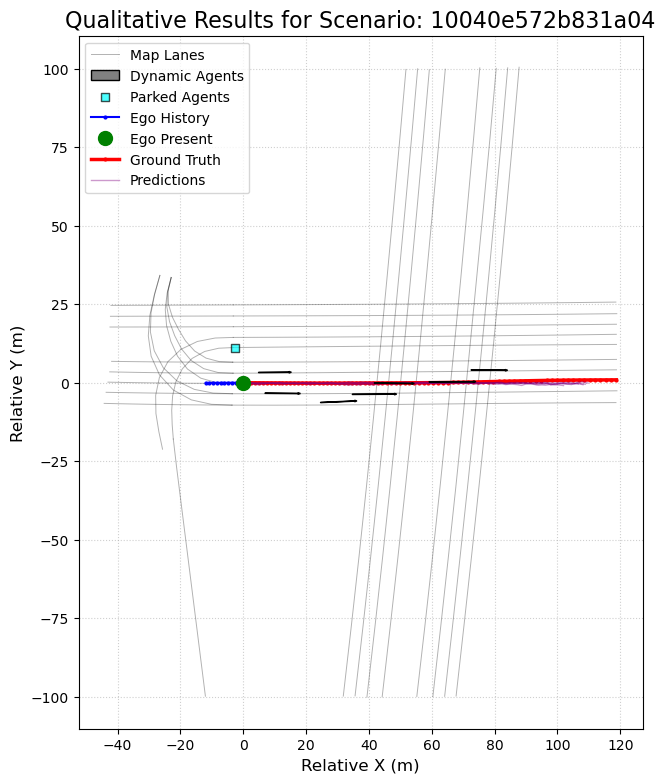


--- Generating visualization for scenario: 1008aa4114dbc237 ---


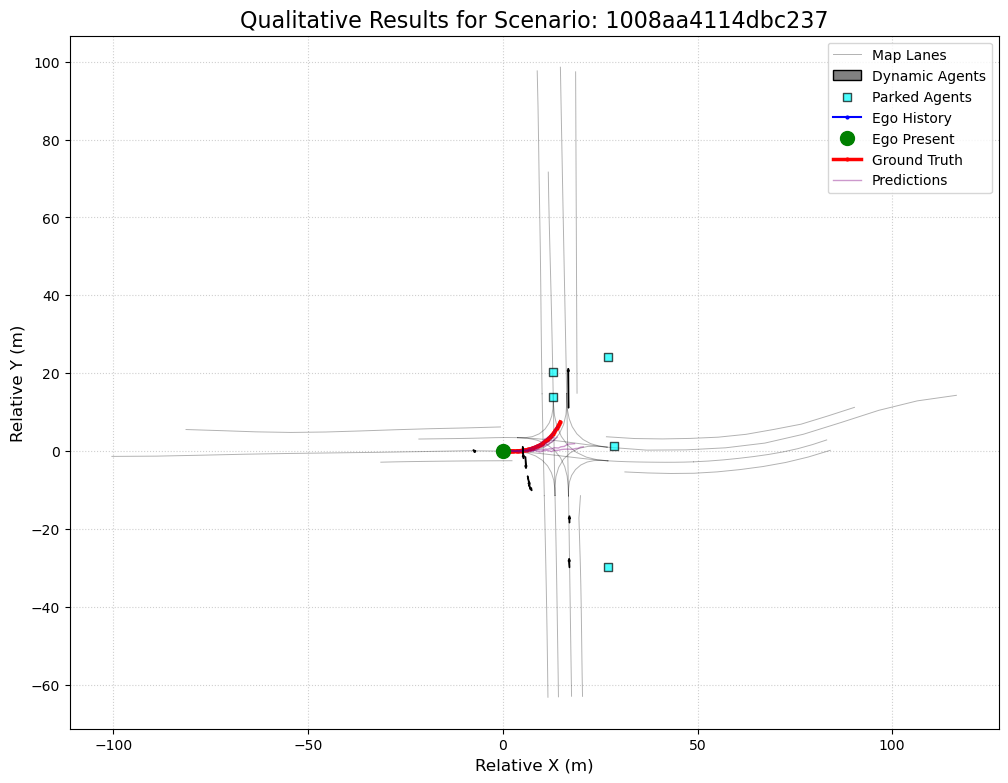


--- Generating visualization for scenario: 1008b7b63e2d60 ---


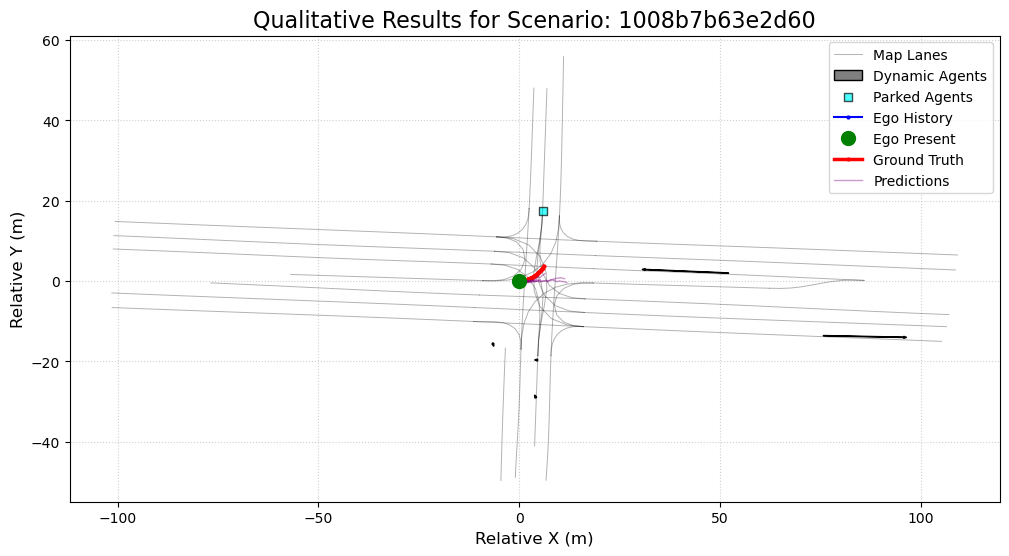


--- Generating visualization for scenario: 1008f05c233dd975 ---


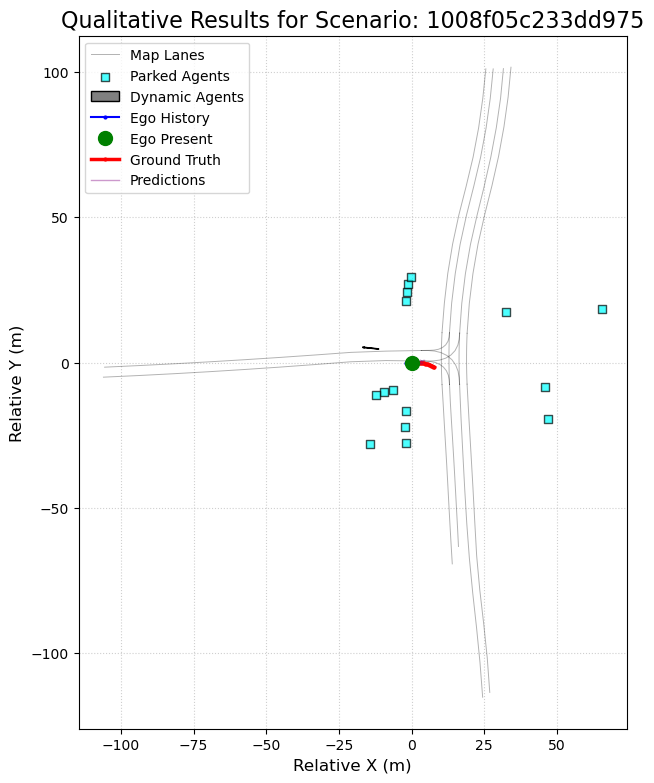


--- Generating visualization for scenario: 1015e9446e86cfa0 ---


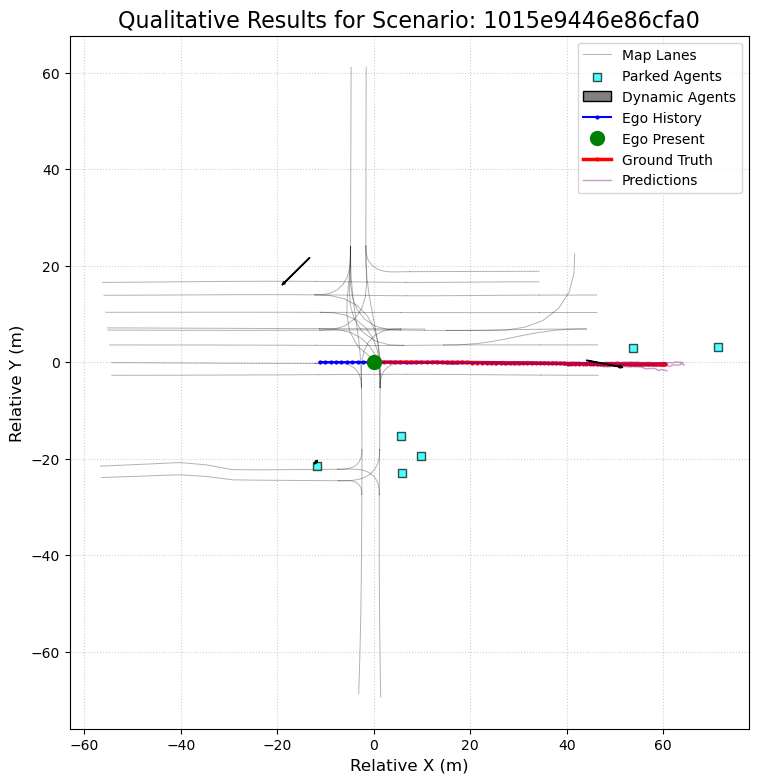


--- Generating visualization for scenario: 101b00dd28e01037 ---


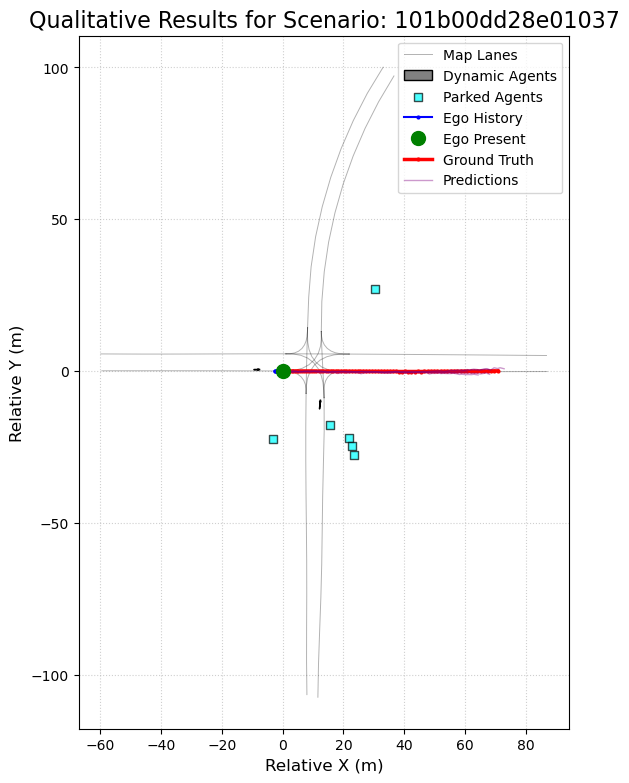


--- Generating visualization for scenario: 101d7af08d9b56ae ---


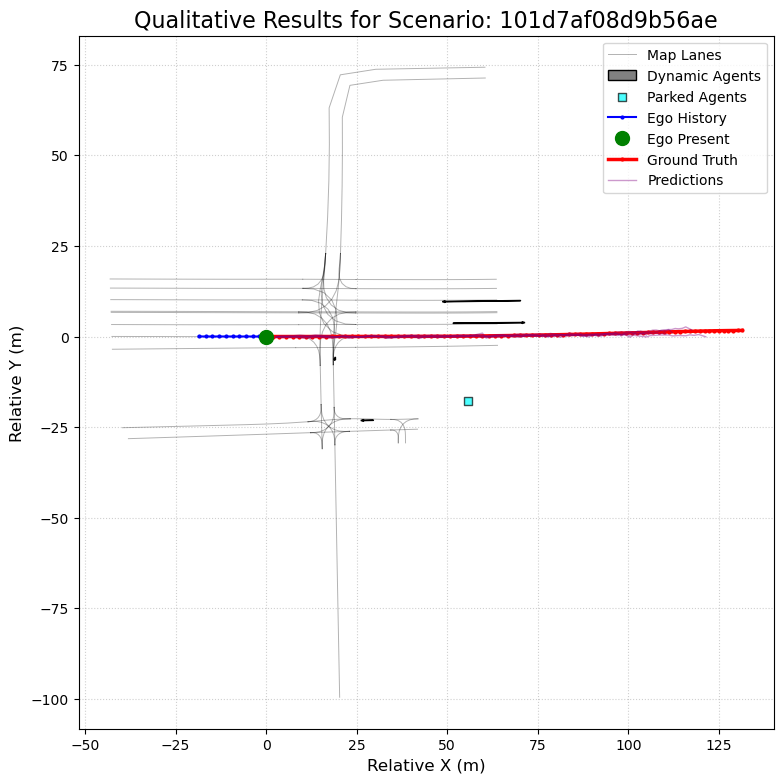


--- Generating visualization for scenario: 102ac3a7db12726a ---


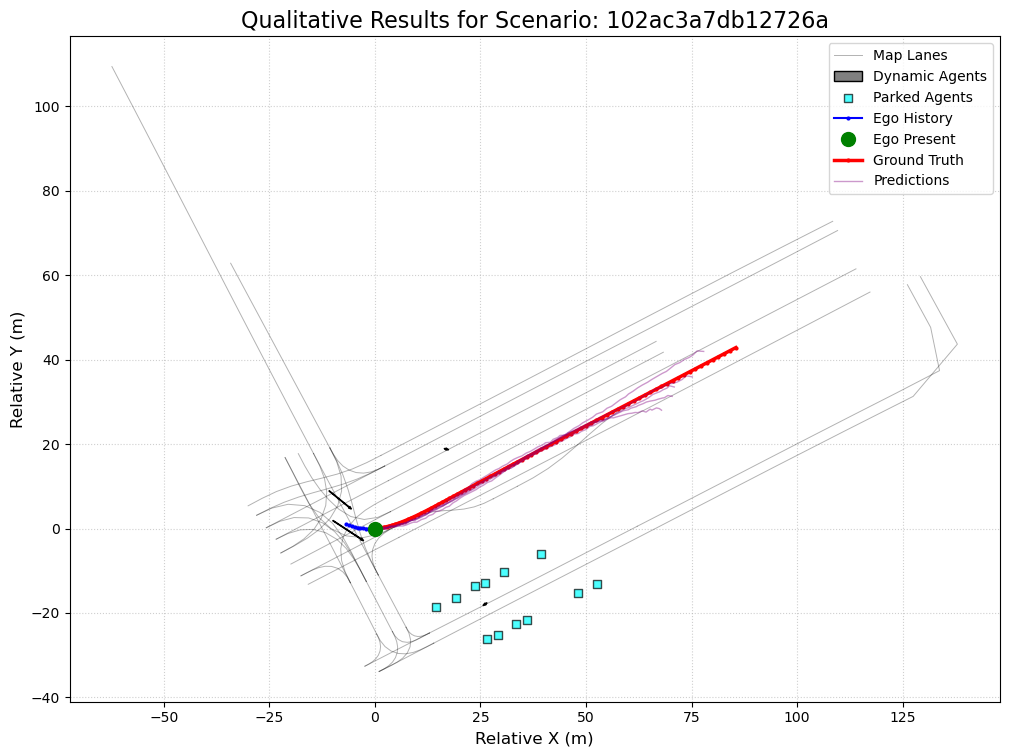


--- Generating visualization for scenario: 10354c249f529dfd ---


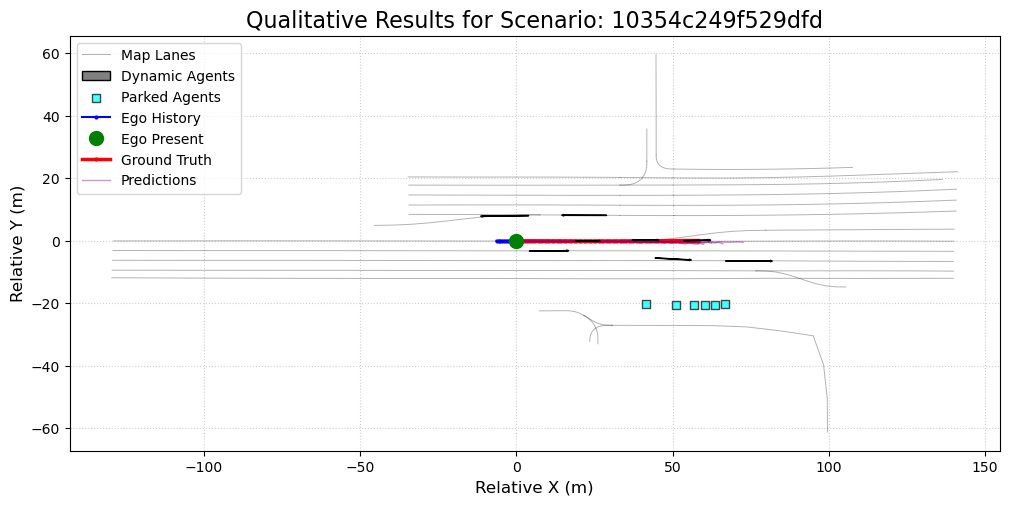


--- Generating visualization for scenario: 103728b58f015a10 ---


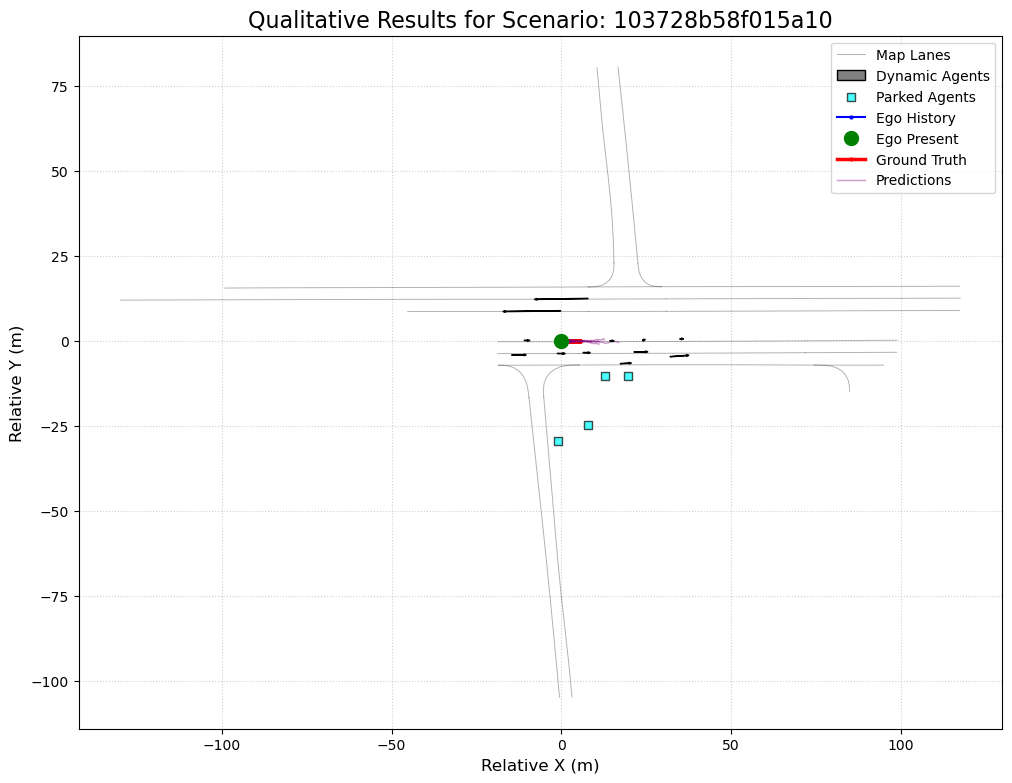

In [11]:
# ==============================================================================
# --- Section 3: Qualitative Analysis (The Visualizations) ---
# ==============================================================================
print("\n--- Preparing for Qualitative Analysis ---")

# --- 3.1: Helper Functions for Visualization ---

def prepare_diffusion_schedule(config: dict, device: str):
    """
    --- UPGRADED VERSION ---
    Pre-computes the DDPM/DDIM schedule constants, now supporting both
    linear and cosine schedules based on the config file.
    """
    schedule_name = config['diffusion']['beta_schedule']
    num_steps = config['diffusion']['num_diffusion_steps']
    
    # --- Generate betas based on the schedule name ---
    if schedule_name == 'linear':
        betas = torch.linspace(
            config['diffusion']['beta_start'], 
            config['diffusion']['beta_end'], 
            num_steps, 
            device=device
        )
    elif schedule_name == 'cosine':
        s = 0.008
        steps = num_steps + 1
        x = torch.linspace(0, num_steps, steps, device=device)
        alphas_cumprod = torch.cos(((x / num_steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clip(betas, 0.0001, 0.9999)
    else:
        raise NotImplementedError(f"Schedule '{schedule_name}' not implemented.")

    # --- Compute the rest of the constants (same for both schedules) ---
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    
    # NOTE: The notebook only uses DDIM, which doesn't need posterior_variance.
    # We can omit it here to keep the helper clean.
    
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    
    return {
        'betas': betas, 
        'alphas_cumprod': alphas_cumprod, 
        'sqrt_alphas_cumprod': torch.sqrt(alphas_cumprod),
        'sqrt_one_minus_alphas_cumprod': torch.sqrt(1.0 - alphas_cumprod),
        'posterior_variance': posterior_variance # <-- Now included in the output
    }

def denormalize_trajectory(trajectory, stats):
    """De-normalizes an (x, y) trajectory from [-1, 1] back to original scale."""
    return ((trajectory + 1) / 2) * (stats['max'] - stats['min']) + stats['min']

@torch.no_grad()
def sample_ddim(model, state_dict, shape, num_steps, schedule, device):
    """
    Performs the fast, deterministic, and numerically stable DDIM sampling process.
    """
    batch_size = shape[0]
    total_steps = schedule['betas'].shape[0]
    
    times = torch.linspace(-1, total_steps - 1, steps=num_steps + 1).long().to(device)
    times = list(reversed(times.tolist()))
    time_pairs = list(zip(times[:-1], times[1:]))
    
    x_t = torch.randn(shape, device=device)

    for time, time_next in time_pairs:
        time_cond = torch.full((batch_size,), time, device=device, dtype=torch.long)
        pred_noise = model(x_t, time_cond, state_dict)
        
        alpha_t = schedule['alphas_cumprod'][time]
        alpha_next = schedule['alphas_cumprod'][time_next] if time_next >= 0 else torch.tensor(1.0, device=device)

        pred_x0 = (x_t - torch.sqrt(1. - alpha_t) * pred_noise) / torch.sqrt(alpha_t)
        pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)
        
        x_t = torch.sqrt(alpha_next) * pred_x0 + torch.sqrt(1. - alpha_next) * pred_noise
        
    return x_t

# --- 3.2: Load Model, Stats, and Validation Data ---
# IMPORTANT: Update this path to your specific 'best_model.pth' checkpoint
CHECKPOINT_PATH = os.path.join(
    PROJECT_ROOT,
    'runs/DiffusionPolicy_Training/20250829_142341/checkpoints/best_model.pth' # <-- UPDATE THIS TIMESTAMP
)

if not os.path.exists(CHECKPOINT_PATH):
    print(f"\nWARNING: Checkpoint not found at '{CHECKPOINT_PATH}'. Please update the path.")
else:
    print(f"\nLoading model from: {CHECKPOINT_PATH}")
    model = ConditionalUNet(config).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
    model.eval()

    print("Loading normalization stats...")
    stats_path = os.path.join(PROJECT_ROOT, 'models', 'normalization_stats.pt')
    STATS = torch.load(stats_path, map_location=DEVICE)

    print("Loading validation dataset for scenario lookup...")
    val_files = glob(os.path.join(config['data']['featurized_dir_onlyxy'], 'validation', '*.pt'))
    # CORRECTED: Pass the stats_path to the dataset constructor
    val_dataset = InMemoryDiffusionDataset(val_files, stats_path=stats_path)
    
    scenario_id_to_idx = {os.path.basename(p).replace('.pt', ''): i for i, p in enumerate(val_files)}
    diffusion_schedule = prepare_diffusion_schedule(config, DEVICE)

# --- 3.3: The Plotting Function (Now expects data in meters) ---
def plot_scenario_with_predictions(scenario_id, state_dict, gt_trajectory_meters, predictions_meters):
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    
    # Plot Map (convert tensors to numpy for plotting)
    map_geometry = state_dict['map'][0].cpu().numpy()
    # ... (rest of the plotting logic is the same as before, but with corrected variable names) ...
    # Plot Map
    map_mask = state_dict['map_mask'][0].cpu().numpy()
    map_plotted_label = False
    for polyline_points in map_geometry[map_mask]:
        label = 'Map Lanes' if not map_plotted_label else None
        ax.plot(polyline_points[:, 0], polyline_points[:, 1], 'k-', linewidth=0.7, alpha=0.3, label=label)
        map_plotted_label = True
        
    # Plot Agents
    agents = state_dict['agents'][0].cpu().numpy()
    agents_mask = state_dict['agents_mask'][0].cpu().numpy()
    valid_agents = agents[agents_mask]
    dynamic_plotted, parked_plotted = False, False
    for agent_state in valid_agents:
        x, y, vx, vy, is_parked = agent_state[0], agent_state[1], agent_state[2], agent_state[3], agent_state[10] > 0.5
        if is_parked:
            label = 'Parked Agents' if not parked_plotted else None
            ax.scatter(x, y, c='cyan', marker='s', s=40, label=label, zorder=4, alpha=0.7, edgecolors='black')
            parked_plotted = True
        else:
            label = 'Dynamic Agents' if not dynamic_plotted else None
            ax.arrow(x, y, vx, vy, head_width=0.5, width=0.1, fc='gray', ec='black', label=label, zorder=5)
            dynamic_plotted = True
            
    # Plot Ego History and Present
    ego_history = state_dict['ego_history'][0].cpu().numpy()
    ax.plot(ego_history[:, 0], ego_history[:, 1], 'b.-', markersize=4, label='Ego History')
    ax.plot(0, 0, 'go', markersize=10, label='Ego Present', zorder=10)
    
    # Plot Ground Truth Trajectory (already in meters)
    ax.plot(gt_trajectory_meters[:, 0], gt_trajectory_meters[:, 1], 'r.-', markersize=4, linewidth=2.5, label='Ground Truth')
    
    # Plot Predicted Trajectories (already in meters)
    for i, pred in enumerate(predictions_meters):
        label = 'Predictions' if i == 0 else None
        ax.plot(pred[:, 0], pred[:, 1], 'purple', linewidth=1.0, alpha=0.4, label=label)

    # ... (rest of the plotting function is the same: title, labels, etc.) ...
    ax.set_title(f'Qualitative Results for Scenario: {scenario_id}', fontsize=16)
    ax.set_xlabel('Relative X (m)', fontsize=12)
    ax.set_ylabel('Relative Y (m)', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='best')
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# --- 3.4: Generate and Display Visualizations ---
if 'model' in locals():
    SCENARIOS_TO_VISUALIZE = list(scenario_id_to_idx.keys())[:10]
    K_SAMPLES_FOR_VIZ = 5
    SAMPLING_STEPS = 100     # Number of DDIM steps (our best-performing setting)

    for scenario_id in SCENARIOS_TO_VISUALIZE:
        print(f"\n--- Generating visualization for scenario: {scenario_id} ---")
        idx = scenario_id_to_idx[scenario_id]
        sample = val_dataset[idx] # Fetches a sample with a NORMALIZED target_trajectory
        
        # --- Create a batch of 1 and move to device ---
        gt_trajectory_normalized = sample['target_trajectory'].unsqueeze(0).to(DEVICE)
        state_dict_torch = {k: torch.from_numpy(v).unsqueeze(0).to(DEVICE) for k, v in sample['state'].items()}
        
        # --- Generate K NORMALIZED predictions ---
        predictions_normalized = []
        for _ in range(K_SAMPLES_FOR_VIZ):
            pred_normalized = sample_ddim(
                model, 
                state_dict_torch, 
                gt_trajectory_normalized.shape, 
                SAMPLING_STEPS, # Use the specified number of DDIM steps
                diffusion_schedule, 
                DEVICE
            )
            predictions_normalized.append(pred_normalized)
            
        
        # --- DE-NORMALIZE everything back to meters for plotting ---
        gt_trajectory_meters = denormalize_trajectory(gt_trajectory_normalized.squeeze(0), STATS).cpu().numpy()
        predictions_meters = [
            denormalize_trajectory(pred.squeeze(0), STATS).cpu().numpy() for pred in predictions_normalized
        ]
            
        # --- Plot the results (now all in meter-space) ---
        plot_scenario_with_predictions(scenario_id, state_dict_torch, gt_trajectory_meters, predictions_meters)